# Assignment

## Importing Libraries

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Datasets

In [2]:
cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())

cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Creating the training dataset

In [547]:
from torch.utils.data import DataLoader
batch_size = 256

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True)

In [548]:
X,y = next(iter(train_iter))

## Creating the test dataset

In [549]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=True)

In [550]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data

In [551]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')
print(f'The output labels are as follows {y}')

The dimensions of each input image is torch.Size([256, 3, 32, 32]) The number of input channels is 3
The output labels are as follows tensor([4, 5, 2, 5, 4, 6, 6, 0, 2, 7, 2, 0, 0, 0, 1, 3, 5, 7, 9, 5, 7, 0, 3, 3,
        8, 4, 0, 6, 3, 2, 2, 3, 0, 5, 2, 2, 3, 8, 1, 1, 0, 8, 3, 8, 3, 8, 4, 7,
        2, 9, 2, 8, 3, 2, 4, 7, 3, 9, 1, 5, 5, 7, 4, 6, 9, 7, 9, 1, 6, 4, 3, 1,
        5, 0, 7, 8, 1, 4, 0, 6, 4, 2, 2, 8, 5, 4, 5, 7, 0, 9, 1, 8, 4, 0, 9, 2,
        8, 6, 9, 9, 7, 0, 7, 8, 8, 9, 2, 2, 7, 6, 7, 5, 2, 2, 4, 0, 4, 2, 5, 4,
        9, 2, 2, 9, 7, 4, 5, 9, 6, 2, 8, 0, 9, 3, 6, 4, 5, 1, 8, 5, 1, 4, 9, 5,
        0, 7, 3, 2, 7, 5, 0, 2, 6, 4, 0, 7, 6, 6, 5, 4, 0, 1, 5, 1, 2, 9, 2, 0,
        7, 4, 6, 4, 6, 1, 9, 3, 7, 7, 7, 4, 0, 5, 9, 9, 8, 4, 0, 2, 7, 8, 5, 5,
        0, 7, 3, 6, 1, 7, 0, 0, 9, 6, 4, 8, 7, 5, 7, 6, 8, 2, 9, 9, 9, 1, 4, 6,
        8, 6, 6, 3, 2, 6, 3, 6, 1, 7, 9, 5, 7, 4, 5, 5, 6, 7, 2, 3, 1, 7, 2, 8,
        6, 3, 0, 4, 6, 2, 8, 7, 5, 5, 1, 3, 2, 4, 6, 7])


## Example image

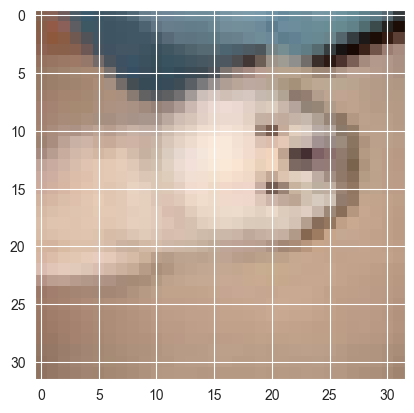

In [552]:
plt.imshow(X[1].T)

## CNN Architecture

In [567]:
class CNN(torch.nn.Module):
    def __init__(self,num_channels,num_outputs):
        super(CNN,self).__init__()
        self.num_channels = num_channels
        self.num_outputs = num_outputs

        #Spatial/Global Pooling for input-------------------------------------------------------
        self.spatial_avg_pool1 = torch.nn.AdaptiveAvgPool2d((24,24))

        # Design the base block Element---------------------------------------------------------
        #Create an input linear layer for future combination

        self.linear1 = torch.nn.Linear(in_features= 442368,out_features=3)
        self.relu1 = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(num_channels,out_channels=96,kernel_size=11,stride=4,padding=2)
        self.batchn1 = torch.nn.BatchNorm2d(96)
        self.relub1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(num_channels,out_channels=256,kernel_size=5,stride=1,padding=1)
        self.batchn2 = torch.nn.BatchNorm2d(96)
        self.relub2 = torch.nn.ReLU()

        self.conv3 = torch.nn.Conv2d(num_channels,out_channels=384,kernel_size=3,stride=5,padding=1)
        self.batchn3 = torch.nn.BatchNorm2d(384)
        self.relub3 = torch.nn.ReLU()

        # Create the spatial average pooling layer for the inputs to the dense---------------------
        self.spatial_avg_pool2 = torch.nn.AdaptiveAvgPool1d(9216)

        # Create the dense,classification block----------------------------------------------------
        # First FC linear layer
        self.linear5 = torch.nn.Linear(in_features=9216,out_features=4096)
        self.relu6 = torch.nn.ReLU()

        self.linear6 = torch.nn.Linear(in_features=4096,out_features=num_outputs)
        self.relu7 = torch.nn.ReLU()

        # Softmax application to get probabilities of classes
        self.softmax = torch.nn.Softmax(dim=1)

        # Initialize the convolutional layers
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.conv3.weight)

        #Define the proportion of neurons to dropout
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self,x):
        # Applying average pooling to downsample the image from 32 -> 24
        a = self.spatial_avg_pool1(x)

        # # First Block------------------------------------------------------
        # #Reshape the tensor to allow for matrix multiplication
        a = torch.flatten(a)

        a = self.linear1(a)
        a = self.relu1(a)

        # # Get outputs of each convolution ->RelU layer
        o1 = self.conv1(x)
        o1 = self.batchn1(o1)
        o1 = self.relub1(o1)

        o2 = self.conv1(x)
        o2 = self.batchn2(o2)
        o2 = self.relub2(o2)

        o3 = self.conv3(x)
        o3 = self.batchn3(o3)
        o3 = self.relub3(o3)

        # concatenate
        O = torch.concat([o1,o2,o3],dim=1)

        # # Prepare the outputs for the second block
        O = torch.matmul(a,O.view(3,-1))

        # # Apply spatial pooling before entering the dense layer------------
        O_bn = self.spatial_avg_pool2(O.view(256,-1))

        # # Move to the dense/classification block
        output = self.linear5(O_bn.view(256,-1))
        output = self.dropout(output)
        output = self.relu6(output)

        output = self.linear6(output)
        output = self.dropout(output)
        output = self.relu7(output)

        output = self.softmax(output)

        return output

In [568]:
model = CNN(num_channels=3,num_outputs=10)
print(model)

CNN(
  (spatial_avg_pool1): AdaptiveAvgPool2d(output_size=(24, 24))
  (linear1): Linear(in_features=442368, out_features=3, bias=True)
  (relu1): ReLU()
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (batchn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relub1): ReLU()
  (conv2): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relub2): ReLU()
  (conv3): Conv2d(3, 384, kernel_size=(3, 3), stride=(5, 5), padding=(1, 1))
  (batchn3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relub3): ReLU()
  (spatial_avg_pool2): AdaptiveAvgPool1d(output_size=9216)
  (linear5): Linear(in_features=9216, out_features=4096, bias=True)
  (relu6): ReLU()
  (linear6): Linear(in_features=4096, out_features=10, bias=True)
  (relu7): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(

In [569]:
model(X).size()

torch.Size([256, 10])

In [570]:
#a,b,c = model(X)

In [571]:
#c.size()

## Create the metric for calculating accuracy

In [572]:
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        cmp = (y_hat.type(y.dtype) == y)
        return float(torch.sum(cmp))

## Create the model training system

In [573]:
def train_model(model,X,y,X_test,y_test,accuracy,epochs):

    # Create the loss component
    loss = torch.nn.CrossEntropyLoss()

    # Create the optimizer term
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005,weight_decay=0.005,momentum=0.9)

    score_train = []
    score_test = []
    l_score = []

    for epoch in range(0,epochs):
        model.train()
        y_hat = model(X)
        l = loss(y_hat,y)

        optimizer.zero_grad()

        l.backward()
        optimizer.step()

        # Training Accuracy
        score_train.append(accuracy(model(X),y)/len(y))

        # Loss graph
        l_score.append(l.item())

        # # Test Accuracy
        # torch.no_grad()
        # model.eval()
        # score_test.append(accuracy(model(X_test),y_test)/len(y_test))

    return score_train,l_score

In [574]:
epochs = 100
s1,loss = train_model(model,X,y,X_test,y_test,accuracy,epochs)

In [564]:
s1

[0.078125,
 0.09765625,
 0.09375,
 0.078125,
 0.12109375,
 0.09375,
 0.10546875,
 0.06640625,
 0.0859375,
 0.05859375,
 0.1171875,
 0.09765625,
 0.08203125,
 0.109375,
 0.09765625,
 0.10546875,
 0.10546875,
 0.08984375,
 0.11328125,
 0.1171875,
 0.10546875,
 0.109375,
 0.109375,
 0.1484375,
 0.12890625,
 0.14453125,
 0.10546875,
 0.10546875,
 0.14453125,
 0.1171875,
 0.1640625,
 0.1796875,
 0.1484375,
 0.1796875,
 0.16796875,
 0.21484375,
 0.21875,
 0.2578125,
 0.23828125,
 0.26171875,
 0.27734375,
 0.2890625,
 0.30859375,
 0.34765625,
 0.28125,
 0.37109375,
 0.375,
 0.37109375,
 0.34765625,
 0.39453125,
 0.40234375,
 0.35546875,
 0.3984375,
 0.375,
 0.39453125,
 0.421875,
 0.40234375,
 0.41796875,
 0.4140625,
 0.40625,
 0.45703125,
 0.4375,
 0.4296875,
 0.4609375,
 0.46484375,
 0.46484375,
 0.44140625,
 0.4609375,
 0.5078125,
 0.48046875,
 0.4453125,
 0.48828125,
 0.50390625,
 0.51953125,
 0.50390625,
 0.49609375,
 0.51171875,
 0.515625,
 0.4765625,
 0.4609375,
 0.4921875,
 0.5078125,

Text(0, 0.5, 'Accuracy')

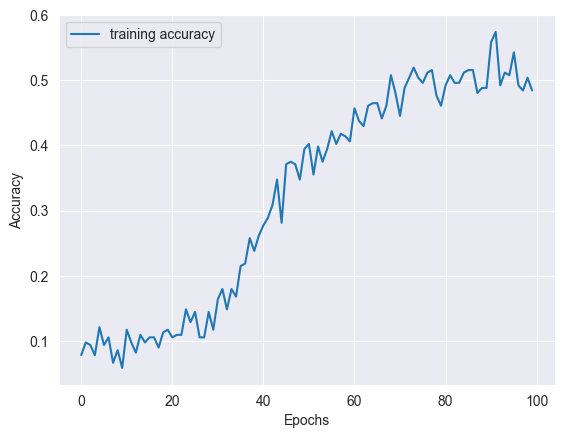

In [565]:
sns.lineplot(x=range(0,epochs),y=s1,label='training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

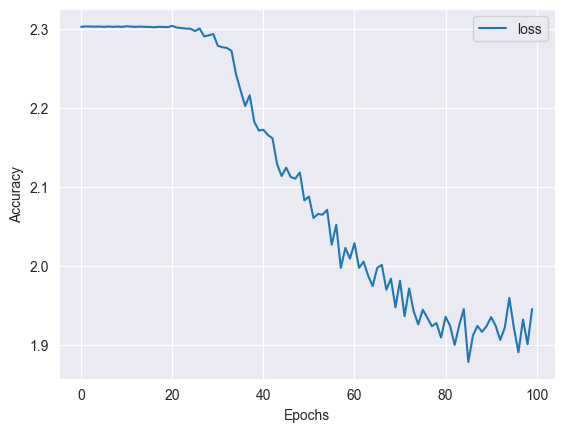

In [566]:
sns.lineplot(x=range(0,epochs),y=loss,label='loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')